# Introduction to LangGraph

LangGraph is a framework for creating applications using graph-based workflows. Each node represents a function or computational step, and edges define the flow between these nodes based on certain conditions.

## Key Features:
- State Management
- Flexible Routing
- Persistence
- Visualization

## Tutorial Overview: Text Analysis Pipeline

In this tutorial, we'll demonstrate the power of LangGraph by building a multi-step text analysis pipeline. Our use case will focus on processing a given text through three key stages:

1. **Text Classification**: We'll categorize the input text into predefined categories (e.g., News, Blog, Research, or Other).
2. **Entity Extraction**: We'll identify and extract key entities such as persons, organizations, and locations from the text.
3. **Text Summarization**: Finally, we'll generate a concise summary of the input text.

This pipeline showcases how LangGraph can be used to create a modular, extensible workflow for natural language processing tasks. By the end of this tutorial, you'll understand how to construct a graph-based application that can be easily modified or expanded for various text analysis needs.

In [2]:
%%capture --no-stderr
%pip install --quiet -U langgraph

In [3]:
!pip install python-dotenv

In [4]:
%pip install -q -U langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.9 MB/s eta 0:00:00


### Set Up API Key


In [5]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

## Building the Text Processing Pipeline

### Define State and Initialize LLM
Here we define the State class to hold our workflow data and initialize the ChatOpenAI model.

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, List

class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str


# Initialize an instance of the ChatGoogleGenerativeAI with specific parameters
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # Specify the model to use
    api_key=google_api_key,     # Provide the Google API key for authentication
)


### Define Node Functions
These functions define the operations performed at each node of our graph: classification, entity extraction, and summarization.

**PromptTemplate**: Helps in creating prompts with placeholders.

**HumanMessage**: Formats the prompt as a message from a human user.

In [7]:
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage

def classification_node(state: State):
    prompt = PromptTemplate(
        input_variables=["text"], # input_variables is a list of variable names that appear as placeholders in the template.
        template="Classify the following text into one of the categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"])) #  Replace the {text} placeholder in the template with the actual text from the state.
    classification = llm.invoke([message]).content.strip()
    return {"classification": classification}


def entity_extraction_node(state: State):
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.invoke([message]).content.strip().split(", ")
    return {"entities": entities}


def summarization_node(state: State):
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).content.strip()
    return {"summary": summary}

### Create Tools and Build Workflow
This cell builds the StateGraph workflow.

In [9]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(State)
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Add edges to the graph
workflow.set_entry_point("classification_node")
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)

# Compile the graph
app = workflow.compile()

## Visualizing the Workflow
This cell creates a visual representation of our workflow using Mermaid

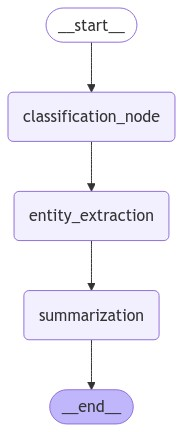

In [10]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Testing the Pipeline
This cell runs a sample text through our pipeline and displays the results.

In [12]:
# Testing the pipeline
sample_text = """
OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes.
"""

state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

Classification: The category is **News**. 

Here's why:

* **Factual and objective:** The text presents factual information about the release of a new AI model, GPT-4, by OpenAI. 
* **Concise and informative:**  It provides key details about the model's capabilities, purpose, and release timeline.
* **No personal opinions or interpretations:**  The text avoids subjective opinions or personal reflections, focusing solely on objective information. 

While the text could be part of a blog post or research paper, the focus on announcing a new development and its key features strongly points to it being a news article.

Entities: ['OpenAI', 'GPT-4', 'GPT-3']

Summary: OpenAI's new multimodal model, GPT-4, demonstrates human-level performance in various professional tasks and prioritizes safety and efficiency.


## Conclusion

In this tutorial, we've:
- Explored LangGraph concepts
- Built a text processing pipeline
- Demonstrated LangGraph's use in data processing workflows
- Visualized the workflow using Mermaid

This example showcases how LangGraph can be used for tasks beyond conversational agents, providing a flexible framework for creating complex, graph-based workflows.